In [1]:
import asyncio
import threading
import scripts
import json
import time
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sklearn.cluster
import skimage
from skimage import morphology
import argparse
import matplotlib.cm as cm

from GMMDetector import MaterialDetector

In [ ]:
# Create some sample data
data = [(-2.6496, 1540), (-2.5996, 1646), (-2.5496, 1540), (-2.4996, 1540), (-2.4495999999999998, 1516), (-2.3996, 1522), (-2.3495999999999997, 1522), (-2.2996, 1548), (-2.2496, 1548), (-2.1995999999999998, 1624), (-2.48762, 0), (-2.53762, 0), (-2.5876200000000003, 0), (-2.63762, 0), (-2.6876200000000003, 0), (-2.73762, 0), (-2.7876200000000004, 0), (-2.8376200000000003, 0), (-2.88762, 0), (-2.9376200000000003, 0), (-2.46112, 0), (-2.51112, 0), (-2.5611200000000003, 0), (-2.61112, 0), (-2.6611200000000004, 0), (-2.71112, 0), (-2.76112, 0), (-2.8111200000000003, 0), (-2.86112, 0), (-2.9111200000000004, 0), (-2.74636, 0), (-2.6963600000000003, 0), (-2.64636, 0), (-2.5963600000000002, 0), (-2.54636, 0), (-2.49636, 0), (-2.4463600000000003, 0), (-2.39636, 0), (-2.3463600000000002, 0), (-2.29636, 0)]
# Extract x and y coordinates into separate lists
x_coords = [point[0] for point in data]
y_coords = [point[1] for point in data]

# Create a scatter plot
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(x_coords, y_coords, c='red', marker='x')
plt.show()


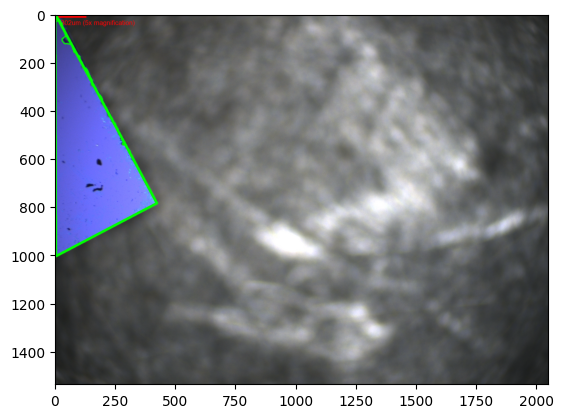

In [5]:
# Convert to YCrCb Channel and extract cb channel
img = cv2.imread('testImageFile.png', cv2.IMREAD_COLOR)
imgYCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
channel = imgYCrCb[:,:,2]

ret, threshold = cv2.threshold(channel, 160,  255, cv2.THRESH_BINARY)


result = img.copy()
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = contours[0] if len(contours) == 2 else contours[1]
resImg = cv2.drawContours(result, contours, -1, (0, 255, 0), 3) 

for cont in contours:
    maxX = cont[0][0]
    maxY = cont[0][0]
    minX = cont[0][0]
    minY = cont[0][0]
    for point in cont:
        pt = point[0]
        if pt[0] > maxX[0]:
            maxX = pt
        elif pt[0] == maxX[0]:
            maxX = [pt[0], max(pt[1], maxX[1])]

        if pt[0] < minX[0]:
            minX = pt
        elif pt[0] == minX[0]:
            minX = [pt[0], min(pt[1], minX[1])]

        if pt[1] > maxY[1]:
            maxY = pt
        elif pt[1] == maxY[1]:
            maxY = [max(pt[0], maxY[0]), pt[1]]

        if pt[1] < minY[1]:
            minY = pt
        elif pt[1] == minY[1]:
            minY = [min(pt[0], maxY[0]), pt[1]]
    cv2.line(result, minX, minY, [0,255,0], 10)
    cv2.line(result, minY, maxX, [0,255,0], 10)
    cv2.line(result, maxX, maxY, [0,255,0], 10)
    cv2.line(result, maxY, minX, [0,255,0], 10)
    # print(f"{minX}, {minY}, {maxX}, {maxY}")

plt.imshow(cv2.cvtColor(resImg, cv2.COLOR_BGR2RGB))
# cv2.imwrite('testFileOut.png', cv2.cvtColor(channel, cv2.COLOR_BGR2RGB))

In [11]:
# Imports for flake testing
def visualise_flakes(
    flakes,
    image: np.ndarray,
    confidence_threshold: float = 0.5,
) -> np.ndarray:
    """Visualise the flakes on the image.

    Args:
        flakes (List[Flake]): List of flakes to visualise.
        image (np.ndarray): Image to visualise the flakes on.
        confidence_threshold (float, optional): The confidence threshold to use, flakes with less confidence are not drawn. Defaults to 0.5.

    Returns:
        np.ndarray: Image with the flakes visualised.
    """

    confident_flakes = [
        flake
        for flake in flakes
        if (1 - flake.false_positive_probability) > confidence_threshold
    ]

    # get a colors for each flake
    colors = cm.rainbow(np.linspace(0, 1, len(confident_flakes)))[:, :3] * 255

    image = image.copy()
    for idx, flake in enumerate(confident_flakes):
        flake_contour = cv2.morphologyEx(
            flake.mask, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8)
        )
        image[flake_contour > 0] = colors[idx]

        # put the text on the top right corner of the image
        cv2.putText(
            image,
            f"{(idx + 1):2}. {flake.thickness:1}L {int(flake.size * 0.3844**2):4}um2 {1- flake.false_positive_probability:.0%}",
            (10, 30 * (idx + 1)),
            cv2.QT_FONT_NORMAL,
            1,
            (255, 255, 255),
            2,
        )

        # draw a line from the text to the center of the flake
        cv2.line(
            image,
            (370, 30 * (idx + 1) - 15),
            (int(flake.center[0]), int(flake.center[1])),
            colors[idx],
            2,
        )

    return image


def remove_vignette(
    image,
    flatfield,
    max_background_value: int = 241,
):
    """Removes the Vignette from the Image

    Args:
        image (NxMx3 Array): The Image with the Vignette
        flatfield (NxMx3 Array): the Flat Field in RGB
        max_background_value (int): the maximum value of the background

    Returns:
        (NxMx3 Array): The Image without the Vignette
    """
    image_no_vigentte = image / flatfield * cv2.mean(flatfield)[:-1]
    image_no_vigentte[image_no_vigentte > max_background_value] = max_background_value
    return np.asarray(image_no_vigentte, dtype=np.uint8)

def arg_parse() -> dict:
    """
    Parse arguments to the detect module

    Returns:
        dict: Dictionary of arguments
    """
    # fmt: off
    parser = argparse.ArgumentParser(description="2DMatGMM Demo")
    parser.add_argument("--out", dest="out", help="Output directory", default="output", type=str)
    parser.add_argument("--num_image", dest="num_image", help="Number of images to process", default=10, type=int)
    parser.add_argument("--material", dest="material", help="Material to process", default="Graphene", type=str)
    parser.add_argument("--size", dest="size", help="Size threshold in pixels", default=200, type=int)
    parser.add_argument("--std", dest="std", help="Standard deviation threshold", default=5, type=float)
    parser.add_argument("--min_confidence", dest="min_confidence", help="The Confidence threshold", default=0, type=float)
    parser.add_argument("--channels", dest="channels", help="Channels to use", default="BGR", type=str)
    parser.add_argument("--shuffel", dest="shuffel", default=False, type=bool)
    # fmt: on
    return vars(parser.parse_args())



In [12]:
args = arg_parse()


usage: ipykernel_launcher.py [-h] [--out OUT] [--num_image NUM_IMAGE]
                             [--material MATERIAL] [--size SIZE] [--std STD]
                             [--min_confidence MIN_CONFIDENCE]
                             [--channels CHANNELS] [--shuffel SHUFFEL]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\wu_pe\AppData\Roaming\jupyter\runtime\kernel-v2-35184okx7nBpIRu5S.json


SystemExit: 2

c:\Users\wu_pe\miniconda3\envs\automatedTransfer\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
from GMMDetector import demo_functions

ImportError: cannot import name 'demo_functions' from 'GMMDetector' (c:\dev\2dmatgmm\GMMDetector\__init__.py)

In [14]:
contrast_dict = json.load(open("../contrastDictDir/Graphene_GMM.json", "r"))